In [1]:
# If you run this notebook on Google Colaboratory, uncomment the below to install automl_alex.
#!pip install -U -q automl-alex

In [1]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

import automl_alex
from automl_alex import DataPrepare

print(automl_alex.__version__)

1.3.4


In [2]:
RANDOM_SEED = 42

# Load Data

In [3]:
dataset = fetch_openml(name='adult', version=1, as_frame=True)
# convert target to binary
dataset.target = dataset.target.astype('category').cat.codes
dataset.data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States
1,3,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States
2,2,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States
3,3,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States
4,1,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba


In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                    dataset.target,
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED,)
X_train.shape, X_test.shape

((39073, 14), (9769, 14))

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39073 entries, 37193 to 15795
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             39073 non-null  category
 1   workclass       36851 non-null  category
 2   fnlwgt          39073 non-null  float64 
 3   education       39073 non-null  category
 4   education-num   39073 non-null  float64 
 5   marital-status  39073 non-null  category
 6   occupation      36842 non-null  category
 7   relationship    39073 non-null  category
 8   race            39073 non-null  category
 9   sex             39073 non-null  category
 10  capitalgain     39073 non-null  category
 11  capitalloss     39073 non-null  category
 12  hoursperweek    39073 non-null  category
 13  native-country  38396 non-null  category
dtypes: category(12), float64(2)
memory usage: 1.3 MB


As we can see, the data is quite dirty, there are object/category features and nans. But the **model is successfully trained even in such a dirty dataset**      
[RUS] Как мы видим, данные довольно грязные, есть object/category признаки и nans. Но модель успешно обучаеться даже таком грязном датасете

# Data Cleaning (DataPrepare)
before entering the AutoML, the data goes through a full cycle of pre-processing in DataPrepare Class     
[RUS] до того как попасть в AutoML, данные проходят полный цикл предобработки в классе DataPrepare. Давайте расмотрим его отдельно

In [6]:
%%time
de = DataPrepare(clean_and_encod_data=True,
                cat_encoder_names=['HelmertEncoder','OneHotEncoder'], # Encoders list for Generator cat encodet features
                clean_nan=True, # fillnan
                clean_outliers=True, # method='IQR', threshold=2,
                drop_invariant=True, # drop invariant features (data.nunique < 2)
                num_generator_features=True, # Generator interaction Num Features
                num_denoising_autoencoder=True, # denoising_autoencoder if num features > 2
                normalization=True, # normalization data (StandardScaler)
                cat_features=None, # DataPrepare can auto detect categorical features
                random_state=RANDOM_SEED,
                verbose=3)
clean_X_train = de.fit_transform(X_train)

06:32:37 | Source data shape: (39073, 14)
06:32:37 | ##################################################
06:32:37 | ! START preprocessing Data
06:32:37 | - Auto detect cat features: 12
06:32:37 | > Binary Features
06:32:37 | > Clean Categorical Features
06:32:37 | > Transform Categorical Features.
06:32:38 |  - Encoder: HelmertEncoder ADD features: 123
06:32:38 |  - Encoder: OneHotEncoder ADD features: 135
06:32:39 |   No nans features
06:32:39 | > CleanOutliers
06:32:39 | Num of outlier detected: 560 in Feature fnlwgt
06:32:39 | Proportion of outlier detected: 1.4 %
06:32:39 | Num of outlier detected: 253 in Feature education-num
06:32:39 | Proportion of outlier detected: 0.6 %
06:32:39 | > Generate interaction Num Features
06:32:39 |  ADD features: 5
06:32:39 | > Normalization Features
06:32:39 | ##################################################
06:32:39 | Final data shape: (39073, 279)
06:32:39 | Total ADD columns: 265
06:32:39 | ##################################################
CP

In [7]:
clean_X_train.head(5)

,sex,HelmertEncoder_age_3,HelmertEncoder_workclass_7,HelmertEncoder_education_14,HelmertEncoder_education-num_14,HelmertEncoder_marital-status_5,HelmertEncoder_occupation_13,HelmertEncoder_relationship_4,HelmertEncoder_race_3,HelmertEncoder_capitalgain_3,...,HelmertEncoder_native-country_34,HelmertEncoder_native-country_35,HelmertEncoder_native-country_36,HelmertEncoder_native-country_37,HelmertEncoder_native-country_38,fnlwgt_/_education-num,fnlwgt_-_education-num,education-num_/_fnlwgt,education-num_-_fnlwgt,fnlwgt_*_education-num
0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,-0.993707,-1.393774,1.279582,1.393774,-1.286950
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,-0.684578,-0.445501,0.222263,0.445501,0.118233
2,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,0.719357,0.647444,-0.636650,-0.647444,0.115378
3,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,-0.855686,-1.203579,0.649488,1.203579,-1.135171
4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,-1.156498,-1.618104,3.085444,1.618104,-1.465968


<img src="./img/magic.gif" width="400">

In [8]:
clean_X_test = de.transform(X_test)

06:32:40 | ##################################################
06:32:40 | ! Start Transform Data
06:32:40 | > Clean Binary Features
06:32:40 | > Clean Categorical Features
06:32:40 | > Transform Categorical Features.
06:32:40 |  - Encoder: HelmertEncoder ADD features: 123
06:32:40 |  - Encoder: OneHotEncoder ADD features: 135
06:32:40 | > Generate interaction Num Features
06:32:40 |  ADD features: 5
06:32:40 | > Normalization Features
06:32:40 | ##################################################
06:32:40 | Final data shape: (9769, 279)
06:32:40 | Total ADD columns: 265
06:32:40 | ##################################################


In [9]:
clean_X_test.head(5)

,sex,HelmertEncoder_age_3,HelmertEncoder_workclass_7,HelmertEncoder_education_14,HelmertEncoder_education-num_14,HelmertEncoder_marital-status_5,HelmertEncoder_occupation_13,HelmertEncoder_relationship_4,HelmertEncoder_race_3,HelmertEncoder_capitalgain_3,...,HelmertEncoder_native-country_34,HelmertEncoder_native-country_35,HelmertEncoder_native-country_36,HelmertEncoder_native-country_37,HelmertEncoder_native-country_38,fnlwgt_/_education-num,fnlwgt_-_education-num,education-num_/_fnlwgt,education-num_-_fnlwgt,fnlwgt_*_education-num
0,1,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,1.743411,2.378030,-0.774084,-2.378030,1.723003
1,0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,0.113351,-0.094857,-0.465758,0.094857,-0.411171
2,1,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,1.199047,1.627886,-0.714685,-1.627886,1.124377
3,0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,0.077113,0.302920,-0.450994,-0.302920,0.263083
4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,0.427323,0.564434,-0.568708,-0.564434,0.275728


## Save and Load
separate transform allows us to save and transfer processing to new data 
[RUS] раздельный transform позволяет нам сохранять и переносить обработку на новые данные

In [12]:
de.save('de', folder='./save/')

06:32:49 | Save DataPrepare


In [13]:
de_new = DataPrepare()
de_new = de.load('de', folder='./save/')

06:32:50 | Load DataPrepare


In [14]:
de_new.transform(X_test).head(5)

06:32:50 | ##################################################
06:32:50 | ! Start Transform Data
06:32:50 | > Clean Binary Features
06:32:50 | > Clean Categorical Features
06:32:50 | > Transform Categorical Features.
06:32:50 |  - Encoder: HelmertEncoder ADD features: 123
06:32:50 |  - Encoder: OneHotEncoder ADD features: 135
06:32:51 | > Generate interaction Num Features
06:32:51 |  ADD features: 5
06:32:51 | > Normalization Features
06:32:51 | ##################################################
06:32:51 | Final data shape: (9769, 279)
06:32:51 | Total ADD columns: 265
06:32:51 | ##################################################


,sex,HelmertEncoder_age_3,HelmertEncoder_workclass_7,HelmertEncoder_education_14,HelmertEncoder_education-num_14,HelmertEncoder_marital-status_5,HelmertEncoder_occupation_13,HelmertEncoder_relationship_4,HelmertEncoder_race_3,HelmertEncoder_capitalgain_3,...,HelmertEncoder_native-country_34,HelmertEncoder_native-country_35,HelmertEncoder_native-country_36,HelmertEncoder_native-country_37,HelmertEncoder_native-country_38,fnlwgt_/_education-num,fnlwgt_-_education-num,education-num_/_fnlwgt,education-num_-_fnlwgt,fnlwgt_*_education-num
0,1,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,1.743411,2.378030,-0.774084,-2.378030,1.723003
1,0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,0.113351,-0.094857,-0.465758,0.094857,-0.411171
2,1,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,1.199047,1.627886,-0.714685,-1.627886,1.124377
3,0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,0.077113,0.302920,-0.450994,-0.302920,0.263083
4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,-0.034332,-0.047411,-0.028698,-0.040404,-0.020771,0.427323,0.564434,-0.568708,-0.564434,0.275728


# Feature Engineering

## Categorical Features 
### Encoders

In [15]:
# available Encoders:
automl_alex._encoders.cat_encoders_names

{'HashingEncoder': category_encoders.hashing.HashingEncoder,
 'SumEncoder': category_encoders.sum_coding.SumEncoder,
 'BackwardDifferenceEncoder': category_encoders.backward_difference.BackwardDifferenceEncoder,
 'OneHotEncoder': category_encoders.one_hot.OneHotEncoder,
 'HelmertEncoder': category_encoders.helmert.HelmertEncoder,
 'BaseNEncoder': category_encoders.basen.BaseNEncoder,
 'CountEncoder': category_encoders.count.CountEncoder}

you can use any encoders for categorical features, combining their results (if you have enough memory)

In [16]:
X_train[['workclass','marital-status']].head(5)

,workclass,marital-status
37193,Private,Married-civ-spouse
31093,State-gov,Married-civ-spouse
33814,Local-gov,Married-civ-spouse
14500,Private,Divorced
23399,Self-emp-not-inc,Widowed


In [17]:
de = DataPrepare(
    cat_encoder_names=['OneHotEncoder',], # Encoders list for Generator cat encodet features
    )  
clean_X_train = de.fit_transform(X_train[['workclass','marital-status']])

06:32:57 | Source data shape: (39073, 2)
06:32:57 | ##################################################
06:32:57 | ! START preprocessing Data
06:32:57 | - Auto detect cat features: 2
06:32:57 | > Clean Categorical Features
06:32:57 | > Transform Categorical Features.
06:32:57 |  - Encoder: OneHotEncoder ADD features: 16
06:32:57 |   No nans features
06:32:57 | > CleanOutliers
06:32:57 | > Normalization Features
06:32:57 | ##################################################
06:32:57 | Final data shape: (39073, 18)
06:32:57 | Total ADD columns: 16
06:32:57 | ##################################################


In [18]:
clean_X_train.head(5)

,OneHotEncoder_workclass_1,OneHotEncoder_workclass_2,OneHotEncoder_workclass_3,OneHotEncoder_workclass_4,OneHotEncoder_workclass_5,OneHotEncoder_workclass_6,OneHotEncoder_workclass_7,OneHotEncoder_workclass_8,OneHotEncoder_workclass_9,OneHotEncoder_marital-status_1,OneHotEncoder_marital-status_2,OneHotEncoder_marital-status_3,OneHotEncoder_marital-status_4,OneHotEncoder_marital-status_5,OneHotEncoder_marital-status_6,OneHotEncoder_marital-status_7,workclass,marital-status
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.578503,-0.938503
1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.008976,-0.938503
2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.596455,-0.938503
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.578503,-0.259678
4,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1.183934,0.419147


**Encoder selection is important part of all AutoML**    

## Numerical Features

### Clean NANs

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39073 entries, 37193 to 15795
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             39073 non-null  category
 1   workclass       36851 non-null  category
 2   fnlwgt          39073 non-null  float64 
 3   education       39073 non-null  category
 4   education-num   39073 non-null  float64 
 5   marital-status  39073 non-null  category
 6   occupation      36842 non-null  category
 7   relationship    39073 non-null  category
 8   race            39073 non-null  category
 9   sex             39073 non-null  category
 10  capitalgain     39073 non-null  category
 11  capitalloss     39073 non-null  category
 12  hoursperweek    39073 non-null  category
 13  native-country  38396 non-null  category
dtypes: category(12), float64(2)
memory usage: 1.3 MB


In [20]:
X_train.isnull().any().any()

True

In [21]:
de = DataPrepare(
    clean_nan=True,
    verbose=0,
    )
clean_X_train = de.fit_transform(X_train)

In [22]:
clean_X_train.isnull().any().any()

False

## Clean Outliers
remove outliers from your data.    
Available two methods solution based on "z score" and solution based on "IQR". default "IQR" 

<img src="./img/boxplot.png" width="600">

In [23]:
# add dataset whis more num features
dataset = fetch_openml(name='credit-g', version=1, as_frame=True)
dataset.target = dataset.target.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=RANDOM_SEED,)
X_train.head(3)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
29,<0,60.0,delayed previously,business,6836.0,<100,>=7,3.0,male single,none,4.0,no known property,63.0,none,own,2.0,skilled,1.0,yes,yes
535,>=200,21.0,critical/other existing credit,education,2319.0,<100,<1,2.0,male div/sep,none,1.0,car,33.0,none,rent,1.0,skilled,1.0,none,yes
695,no checking,6.0,existing paid,used car,1236.0,500<=X<1000,1<=X<4,2.0,male single,none,4.0,life insurance,50.0,none,rent,1.0,skilled,1.0,none,yes


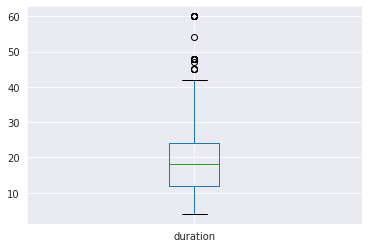

In [24]:
X_train.boxplot(column=['duration',])

In [25]:
de = DataPrepare(
    clean_outliers=True,
    outliers_method='IQR', # method : ['IQR', 'z_score',]
    outliers_threshold=1.5,
    )
clean_X_train = de.fit_transform(X_train)

06:33:04 | Source data shape: (800, 20)
06:33:04 | ##################################################
06:33:04 | ! START preprocessing Data
06:33:04 | - Auto detect cat features: 13
06:33:04 | > Binary Features
06:33:04 | > Clean Categorical Features
06:33:04 | > Transform Categorical Features.
06:33:04 |  - Encoder: HelmertEncoder ADD features: 39
06:33:04 |  - Encoder: CountEncoder ADD features: 13
06:33:04 |   No nans features
06:33:04 | > Start fit DenoisingAutoencoder
Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
06:33:09 | > Add Denoising features
06:33:09 | > CleanOutliers
06:33:09 | Num of outlier detected: 54 in Feature duration
06:33:09 | Proportion of outlier detected: 6.8 %
06:33:09 | Num of outlier detected: 58 in Feature credit_amo

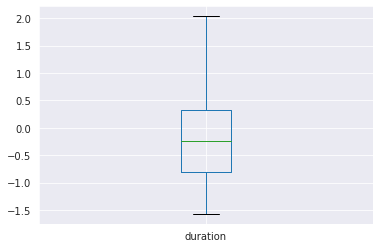

In [26]:
clean_X_train.boxplot(column=['duration',])

try different values threshold and method

### Generator interaction Num Features
Numerical interaction generator features: A/B, A*B, A-B, A+B

In [27]:
de = DataPrepare(
                num_generator_features=True, # Generator interaction Num Features
                operations_num_generator=['/','*','-',],
                )
clean_X_train = de.fit_transform(X_train)

06:33:09 | Source data shape: (800, 20)
06:33:09 | ##################################################
06:33:09 | ! START preprocessing Data
06:33:10 | - Auto detect cat features: 13
06:33:10 | > Binary Features
06:33:10 | > Clean Categorical Features
06:33:10 | > Transform Categorical Features.
06:33:10 |  - Encoder: HelmertEncoder ADD features: 39
06:33:10 |  - Encoder: CountEncoder ADD features: 13
06:33:10 |   No nans features
06:33:10 | > Start fit DenoisingAutoencoder
Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
06:33:15 | > Add Denoising features
06:33:15 | > CleanOutliers
06:33:15 | Num of outlier detected: 10 in Feature duration
06:33:15 | Proportion of outlier detected: 1.2 %
06:33:15 | Num of outlier detected: 38 in Feature credit_amo

In [28]:
clean_X_train.head(5)

,num_dependents,own_telephone,foreign_worker,HelmertEncoder_checking_status_2,HelmertEncoder_credit_history_3,HelmertEncoder_savings_status_3,HelmertEncoder_employment_3,HelmertEncoder_installment_commitment_2,HelmertEncoder_personal_status_2,HelmertEncoder_other_parties_1,...,credit_amount_*_age,credit_amount_*_existing_credits,credit_amount_*_residence_since,credit_amount_*_installment_commitment,age_*_existing_credits,age_*_residence_since,age_*_installment_commitment,existing_credits_*_residence_since,existing_credits_*_installment_commitment,residence_since_*_installment_commitment
0,1.0,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,3.092961,2.068558,2.101616,1.656095,2.493409,2.426710,1.541039,1.576737,0.742693,0.742980
1,1.0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.383651,-0.522170,-0.813868,-0.575610,-0.599913,-1.180281,-0.738207,-1.229023,-0.900888,-1.364766
2,1.0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.528226,-0.769308,-0.508048,-0.880202,-0.034467,1.570256,-0.108172,-0.026555,-0.900888,-0.100118
3,1.0,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.289405,1.231985,1.247417,-0.524283,0.231625,0.186752,-1.423834,1.576737,-0.900888,-0.943216
4,1.0,0,1,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,...,-0.952262,-0.849178,-0.877595,-0.729453,-0.999052,-1.032048,-0.404659,-0.828200,-0.079097,-0.100118


### Normalization

In [36]:
de = DataPrepare(
    normalization=True, # normalization data - StandardScaler
    verbose=0,
    )
clean_X_train = de.fit_transform(X_train)
clean_X_train.head(5)

,num_dependents,own_telephone,foreign_worker,HelmertEncoder_checking_status_2,HelmertEncoder_credit_history_3,HelmertEncoder_savings_status_3,HelmertEncoder_employment_3,HelmertEncoder_installment_commitment_2,HelmertEncoder_personal_status_2,HelmertEncoder_other_parties_1,...,credit_amount_*_age,credit_amount_*_existing_credits,credit_amount_*_residence_since,credit_amount_*_installment_commitment,age_*_existing_credits,age_*_residence_since,age_*_installment_commitment,existing_credits_*_residence_since,existing_credits_*_installment_commitment,residence_since_*_installment_commitment
0,1.0,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,3.092961,2.068558,2.101616,1.656095,2.493409,2.426710,1.541039,1.576737,0.742693,0.742980
1,1.0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.383651,-0.522170,-0.813868,-0.575610,-0.599913,-1.180281,-0.738207,-1.229023,-0.900888,-1.364766
2,1.0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.528226,-0.769308,-0.508048,-0.880202,-0.034467,1.570256,-0.108172,-0.026555,-0.900888,-0.100118
3,1.0,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.289405,1.231985,1.247417,-0.524283,0.231625,0.186752,-1.423834,1.576737,-0.900888,-0.943216
4,1.0,0,1,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,...,-0.952262,-0.849178,-0.877595,-0.729453,-0.999052,-1.032048,-0.404659,-0.828200,-0.079097,-0.100118


Even with such smart preprocessing, don't forget the basic DS rule: **Garbage in the input is garbage in the output.**

[RUS] Даже с такой умной предобработкой не забывайте: Мусор на входе - мусор на выходе.

<img src="./img/data-cleaning.png" width="700">